# Quantum Circuit ECDLP

## Algorithm

The goal is to find the integer $k$ in the equation $Q = kP$ where $P$ is the base point on an elliptic curve and $Q$ is the public point by implementing Shor's algorithm.

Shor's algorithm is _period finding_. For ECDLP, we need to find integers $(r_a, r_b)$ such that
$$
f(a, b) = aP + bQ
$$
satisfies $f(a + r_a, b + r_b) = f(a, b)$ for all $a, b$. $P$ is the known base point (also sometimes called the generator point) and $Q$ is the given public point that gives the public key. Finding a non-trivial pair $(r_a, r_b)$ with
$$
r_a P + r_b Q = \mathcal{O} \text{  (Identity Point)}
$$
implies
$$
r_a P = - r_b Q \\
r_a P  = - r_b (kP) \\
r_a P = - (r_b k) P \\
(r_a + r_b k) P = \mathcal{O}
$$

If the groups order is $n$, we get
$$
r_a + r_b k \equiv 0 \mod n\\
k \equiv -r_a r_b^{-1} \mod n
$$ 

Meaning that once the quantum algorithm finds $r_a$ and $r_b$, the integer (private key) $k$ can be computed classicaly by taking the modular inverse.


## Setup
Import Qiskit and required python libraries

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT, UnitaryGate, IntegerComparator
from qiskit.circuit.library.arithmetic.adders import DraperQFTAdder    # QFT‐based adder :contentReference[oaicite:2]{index=2}
from qiskit.circuit.library.arithmetic.multipliers.rg_qft_multiplier import RGQFTMultiplier  # QFT‐multiplier :contentReference[oaicite:3]{index=3}

## Define Elliptic Curve Parameters
Choose a small prime field, curve equation, base point $P$, and private key $k$.

In this example, we are using
$$
y^2 = x^3 + 2x + 1 \mod 5 
$$

In [15]:
p = 5 # prime modulus
a = 2
b = 1
G = (0, 1) # the generator point
INF = (p, p)

## Classical Preprocessing
Computing the corresponding public point $Q = kP$

Here we use the helpers functions constructed in [Elliptic-Curves.ipynb](Elliptic-Curves.ipynb) to classically compute the public point $Q$.

In [16]:
# simplify modular inverse
def minverse(A: int, p: int) -> int: return pow(A, -1, p)


# point addition
def add(Q, P, a, p):
    if P is None: return Q
    if Q is None: return P
    if P == INF: return Q
    if Q == INF: return P
    # if the points are the same, then double
    if Q == P:
        return double(Q, a, p)

    xq, yq = Q
    xp, yp = P
    if xq == xp and (yq + yp) % p == 0:
        return None
    if p:
        slope = ((yq - yp) * minverse((xq - xp), p)) % p
        xr = (slope**2 - xp - xq) % p
        yr = (slope*(xp - xr) - yp) % p
    else:
        slope = (yq - yp) / (xq - xp)
        xr = (slope**2 - xp - xq)
        yr = (slope*(xp - xr) - yp)

    return xr, yr


# point doubling
def double(Q, a, p):
    xq, yq = Q
    if p:
        slope = (((3 * xq**2 + a) % p) * minverse((2 * yq), p)) % p
        x = (slope**2 - 2*xq) % p
        y = (slope*(xq - x) - yq) % p
    else:
        slope = (3 * xq**2 + a) / (2 * yq)
        x = (slope**2 - 2*xq)
        y = (slope*(xq - x) - yq)

    return x, y

# double and add algorithm
from numpy import binary_repr
def double_and_add(n: int, P: tuple[int, int], a: int, p: int):
    bits = binary_repr(n)
    Q = None                        # identity element
    for bit in bits:
        if Q is not None:
            Q = double(Q, a, p)
        if bit == '1':
            Q = add(Q, P, a, p)
    return Q

Say our private key is $k = 3$, then our public point $Q = kP$ is:

In [17]:
k = 3
Q = double_and_add(k, G, a, p)
print(Q)

(3, 3)


## Quantum Circuit Construction
The quantum circuit that encodes the function $f(a, b) = aP + bQ$ and performs the period-finding routine.

In [18]:
# compute the order of P and use it to find number of qubits needed
group = [None]
R = G
while R is not None:
    group.append(R)
    R = add(R, G, a, p)
n = len(group)
n_bits  = math.ceil(math.log2(n))

# classically precompute the points [2^i]P and [2^i]Q
precomp_P = [double_and_add(2**i, G, a, p) for i in range(n_bits)]
precomp_Q = [double_and_add(2**i, Q, a, p) for i in range(n_bits)]

def make_point_add_gate(R, a, p, n_bits):
    dim = 2**(2*n_bits)
    mat = np.zeros((dim, dim), dtype=complex)
    
    valid = {(x, y) for x in range(p) for y in range(p) if (y*y - (x**3 + a*x + b)) % p == 0}
    identity_coord = (p, p)
    
    # helper: encode (x,y) to index
    def idx(xy):
        x, y = xy
        return (x << n_bits) | y
    
    def add_on_curve(xy):
        return add(xy if xy != identity_coord else None, R, a, p) or identity_coord

    # build permutation matrix
    for k in range(dim):
        x = (k >> n_bits) & ((1 << n_bits) - 1)
        y = k & ((1 << n_bits) - 1)
        if (x, y) in valid or (x, y) == identity_coord:
            new = add_on_curve((x, y))
            j = idx(new)
        else:
            j = k
        mat[j, k] = 1

    return UnitaryGate(mat, label=f"add_{R}")

e1 = QuantumRegister(n_bits, "exp1")
e2 = QuantumRegister(n_bits, "exp2")
x_acc = QuantumRegister(n_bits, "xacc")
y_acc = QuantumRegister(n_bits, "yacc")
# classical registers
c1 = ClassicalRegister(n_bits, "c1")
c2 = ClassicalRegister(n_bits, "c2")

qc = QuantumCircuit(e1, e2, x_acc, y_acc, c1, c2)

# this initializes the coord register to the identity
bin_p = format(p, f'0{n_bits}b')[::-1]
for i, bit in enumerate(bin_p):
    if bit == '1':
        qc.x(x_acc[i])
        qc.x(y_acc[i])

# initialize exp registers
qc.h(e1)
qc.h(e2)

# apply controlled point additions
for i in range(n_bits):
    gateP = make_point_add_gate(precomp_P[i], a, p, n_bits)
    qc.append(gateP.control(1), [e1[i]] + x_acc[:] + y_acc[:])
for i in range(n_bits):
    gateQ = make_point_add_gate(precomp_Q[i], a, p, n_bits)
    qc.append(gateQ.control(1), [e2[i]] + x_acc[:] + y_acc[:])

# inverse QFT on exponent registers
inv_qft = QFT(n_bits, do_swaps=False).inverse()
qc.append(inv_qft, e1)
qc.append(inv_qft, e2)

# measurements
qc.measure(e1[::-1], c1)
qc.measure(e2[::-1], c2)

## Circuit Visualization

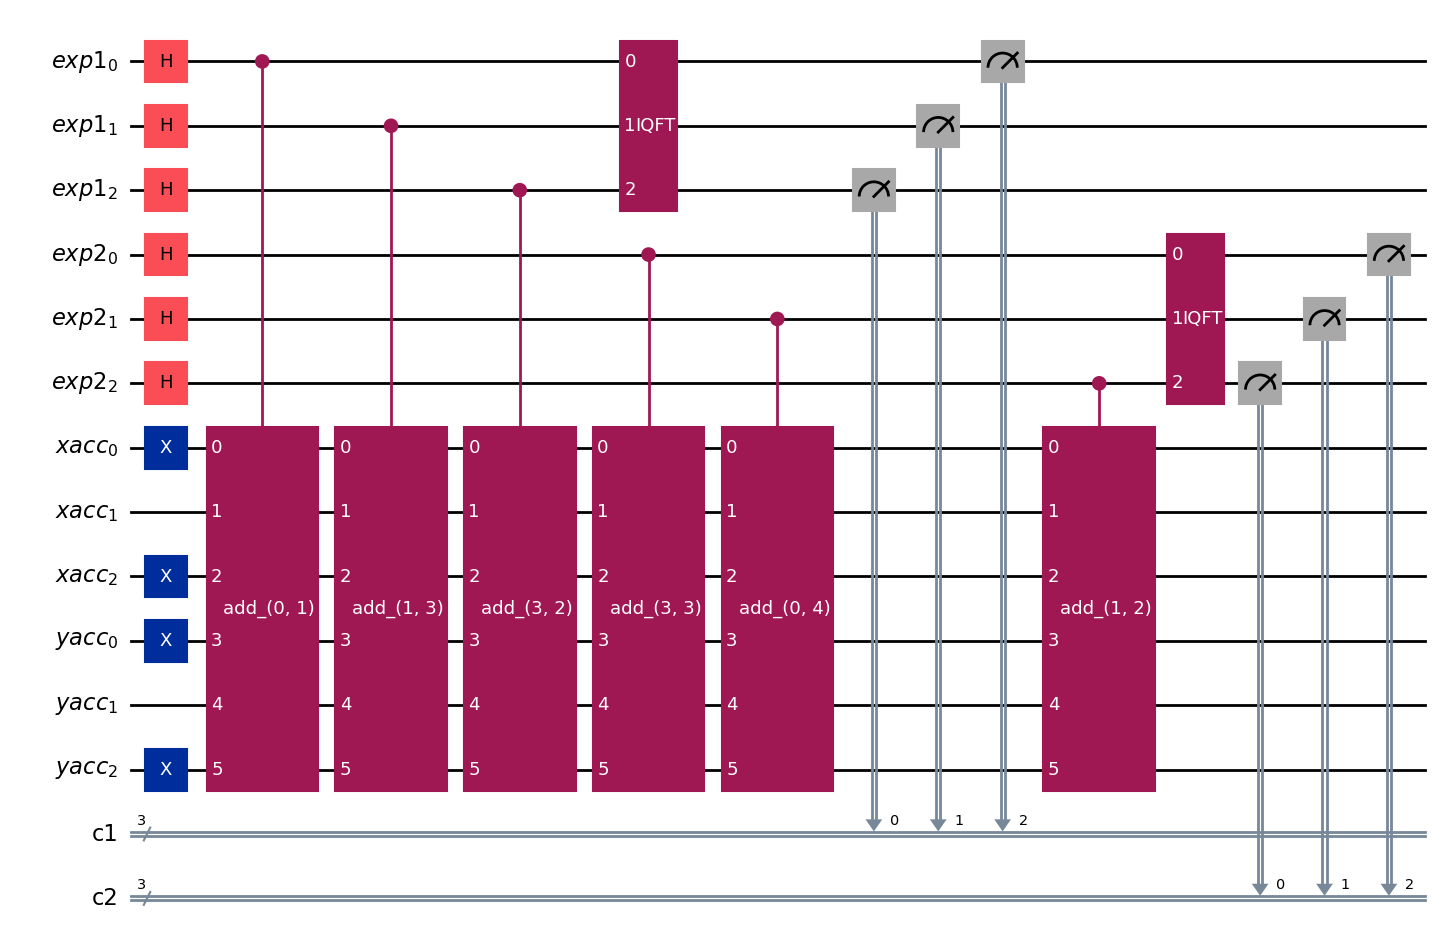

In [19]:
qc.draw(output='mpl')

## Quantum Circuit Execution
Simulating the circuit on a quantum simulator and collecting measurement results

In [22]:
sim = AerSimulator()
tqc = transpile(qc, sim)
job = sim.run(tqc, shots=512)
res = job.result()
counts = res.get_counts()
print(counts)

{'000 110': 2, '100 101': 3, '110 100': 2, '000 100': 2, '011 110': 5, '111 110': 4, '011 000': 2, '010 010': 7, '111 101': 13, '101 110': 4, '101 010': 4, '000 010': 1, '111 000': 3, '011 111': 9, '010 101': 4, '111 011': 11, '001 001': 3, '011 011': 8, '001 011': 10, '111 111': 6, '101 101': 6, '110 011': 6, '101 000': 1, '001 100': 6, '111 100': 12, '111 010': 9, '100 011': 8, '010 111': 19, '010 001': 1, '010 110': 9, '100 110': 24, '010 000': 1, '111 001': 15, '100 001': 18, '000 101': 1, '000 000': 70, '110 001': 6, '011 101': 8, '100 100': 11, '001 110': 6, '110 111': 18, '010 011': 5, '100 010': 19, '110 010': 7, '101 011': 12, '101 001': 2, '100 111': 12, '101 100': 15, '001 010': 11, '001 101': 5, '101 111': 3, '011 100': 26, '110 101': 3, '001 111': 8, '110 110': 10, '010 100': 14, '011 010': 2}


## Postprocessing Results
Interpreting the measured output (recover $r_a, r_b$) and computing the estimated "private key"

In [23]:
samples = []
for bitstr, freq in counts.items():
    k_bits = bitstr[:n_bits]
    l_bits = bitstr[n_bits:]
    k_bits, l_bits = bitstr.split(' ')
    k_sample = int(k_bits, 2)
    l_sample = int(l_bits, 2)
    samples += [(k_sample, l_sample)] * freq

candidates = []
for k_sample, l_sample in samples:
    if l_sample % n != 0:
        m_cand = (-k_sample * minverse(l_sample, n)) % n
        candidates.append(m_cand)

from collections import Counter
m_est, count = Counter(candidates).most_common(1)[0]
counter_counts = Counter(candidates)
print(counter_counts)
print(f"Estimate m = {m_est} mod {n} (seen {count} times)")

Counter({0: 70, 3: 63, 4: 56, 1: 54, 6: 45, 5: 44, 2: 28})
Estimate m = 0 mod 7 (seen 70 times)


## Note
- The QFT doesn't have enough resolution due to the low number of qubits used in the exponent register. Increasing the qubit count decreases the width of the QFT bins which allows to approximate the periodicy much more finely. In other words, it's important to have $ M >> r $ where $M = 2^{n_{exp}}$ and $r$ is the period of the sequence of repeated additions with $P$.
- Adding qubits to the exponent register is computationally expensive on this classical simulator due to the way modular arithmetic is being implemented before the QFT
- For this reason, the expected answer of $m=3$ is not computed with high probability